In [33]:
#imports
import pandas as pd #Python data analysis library
import numpy as np #Python scientific computing
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import matplotlib.pyplot as plt

In [34]:
#import dataset
trainDf = pd.read_csv("order_products__train.csv") 
orderDf = pd.read_csv("orders.csv")
productDf = pd.read_csv("products.csv")


In [ ]:
priorDf = pd.read_csv("order_products__prior.csv") # order_number must refer to the sequence of orders placed by the customer
trainDf = trainDf.append(priorDf,ignore_index = True)

In [36]:
trainDf['reordered'] = 1 

In [37]:
productCountDf = trainDf.groupby("product_id",as_index = False)["order_id"].count()


In [38]:
#Top 100 most frequently purchased products
topLev = 100

#Here order_id is the count so we need to sort the data frame w.r.t order_id
productCountDf = productCountDf.sort_values("order_id",ascending = False)

topProdFrame = productCountDf.iloc[0:topLev,:]
topProdFrame = topProdFrame.merge(productDf,on = "product_id")
productId= topProdFrame.loc[:,["product_id"]]

In [ ]:
df = trainDf[0:0]
for i in range(0,99):
    pId = productId.iloc[i]['product_id'] 
    stDf = trainDf[trainDf.product_id == pId ]
    df = df.append(stDf,ignore_index = False)

In [40]:
df.head()

,order_id,product_id,add_to_cart_order,reordered
115,226,24852,2,1
156,473,24852,2,1
196,878,24852,2,1
272,1042,24852,1,1
297,1139,24852,1,1


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3685725 entries, 115 to 16075326
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 140.6 MB


In [42]:
basket = df.groupby(['order_id', 'product_id'])['reordered'].sum().unstack().reset_index().fillna(0).set_index('order_id')

In [43]:
# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1   

In [44]:
basket_sets = basket.applymap(encode_units)

In [57]:
basket_sets.head()

product_id,196,3957,4210,4605,4799,4920,5077,5450,5785,5876,...,46667,46906,46979,47144,47209,47626,47766,48679,49235,49683
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
basket_sets.size

114592302

In [47]:
# Build up the frequent items
frequent_itemsets = apriori(basket_sets, min_support=0.006, use_colnames=True)

In [48]:
frequent_itemsets

,support,itemsets
0,0.015265,(196)
1,0.015838,(3957)
2,0.015130,(4210)
3,0.031824,(4605)
4,0.015437,(4799)
...,...,...
211,0.006937,"(47209, 45007)"
212,0.006466,"(47209, 47626)"
213,0.010719,"(47626, 47766)"
214,0.006359,"(49683, 47766)"


In [49]:
# Create the rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(24852),(4605),0.201643,0.031824,0.009320,0.046221,1.452399,0.002903,1.015095
1,(4605),(24852),0.031824,0.201643,0.009320,0.292866,1.452399,0.002903,1.129004
2,(13176),(4920),0.161972,0.036138,0.006007,0.037086,1.026231,0.000154,1.000984
3,(4920),(13176),0.036138,0.161972,0.006007,0.166220,1.026231,0.000154,1.005096
4,(4920),(21137),0.036138,0.113433,0.006130,0.169615,1.495283,0.002030,1.067657
...,...,...,...,...,...,...,...,...,...
209,"(13176, 21137)",(47209),0.026928,0.089865,0.006471,0.240303,2.674032,0.004051,1.198023
210,"(47209, 21137)",(13176),0.017261,0.161972,0.006471,0.374894,2.314562,0.003675,1.340617
211,(13176),"(47209, 21137)",0.161972,0.017261,0.006471,0.039951,2.314562,0.003675,1.023634
212,(47209),"(13176, 21137)",0.089865,0.026928,0.006471,0.072006,2.674032,0.004051,1.048576


In [50]:
rules[ (rules['lift'] >= 2) &
       (rules['confidence'] >= 0.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,(5876),(47209),0.037282,0.089865,0.008967,0.240511,2.676345,0.005616,1.198351
19,(8174),(13176),0.018509,0.161972,0.006110,0.330097,2.037991,0.003112,1.250970
27,(8277),(47209),0.035305,0.089865,0.006441,0.182425,2.029986,0.003268,1.113213
92,(21137),(27966),0.113433,0.058129,0.014693,0.129529,2.228306,0.008099,1.082024
93,(27966),(21137),0.058129,0.113433,0.014693,0.252764,2.228306,0.008099,1.186462
97,(39275),(21137),0.043550,0.113433,0.010410,0.239025,2.107181,0.005469,1.165040
136,(24964),(22935),0.046670,0.048045,0.009328,0.199870,4.160066,0.007086,1.189751
137,(22935),(24964),0.048045,0.046670,0.009328,0.194149,4.160066,0.007086,1.183010
180,(26209),(24964),0.060266,0.046670,0.006873,0.114051,2.443804,0.004061,1.076056
181,(24964),(26209),0.046670,0.060266,0.006873,0.147279,2.443804,0.004061,1.102041


In [51]:
datanew = rules[ (rules['lift'] >= 2) &
       (rules['confidence'] >= 0.1) ]

In [52]:
G = nx.Graph() 

In [58]:
G = nx.from_pandas_edgelist(datanew,'antecedents','consequents','lift')

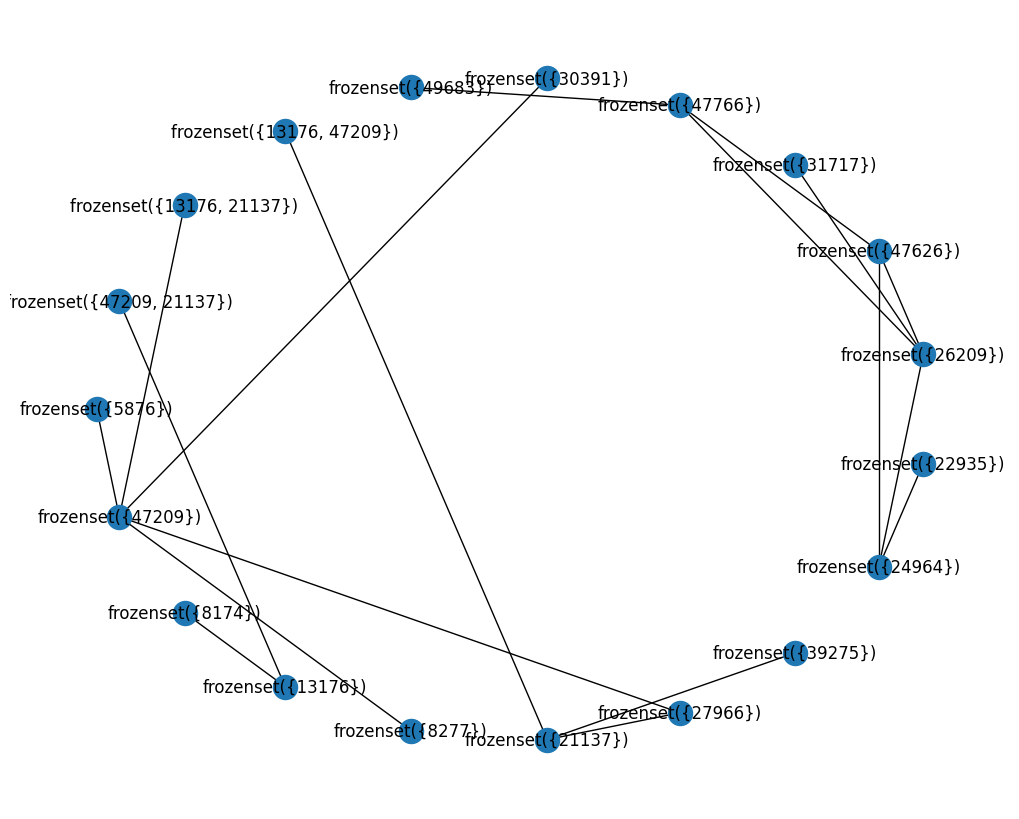

In [59]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)